In [1]:
suppressPackageStartupMessages({
  library(Seurat)
  library(ggplot2)
  library(dplyr)
  library(pagoda2)
  library(cowplot)
  library(magrittr)
  library(ggrastr)
  library(data.table)
  library(dataorganizer)
  library(devtools)
  library(readr)

  devtools::load_all()
})

suppressMessages({
  load_arial_font()
})

ℹ Loading cellAdmixNotebooks


In [2]:
# load gut data
data <- prepare_gut_tx_and_meta(rm_small_cells=FALSE)
cell_annot <- data[[1]]
df <- data[[2]]

seurat_spatial <- get_counts_meta_seurat(df,normalize=TRUE)

Idents(seurat_spatial) <- as.factor(seurat_spatial@meta.data$cell_type)
table(Idents(seurat_spatial))

# load tissue-matched scRNA-seq data
sc_obj <- prepare_gut_scrna()

Normalizing layer: counts




               B      Endothelial       Enterocyte           Goblet 
             558              194             2577              403 
             ICC  Macrophage + DC Myenteric Plexus           Paneth 
              43              458               24              161 
        Pericyte    Smooth Muscle        Stem + TA          Stromal 
             107              627             1082              611 
               T         Telocyte             Tuft 
             336              142               20 

In [3]:
## run DE between sc cell types
sc_pgda <- basicP2proc(sc_obj[['RNA']]$counts, n.cores=1, min.cells.per.gene=0, min.transcripts.per.cell = 10,
                       n.odgenes=2e3, get.largevis=FALSE, make.geneknn=FALSE, get.tsne = FALSE)

ct_annot <- Idents(sc_obj)
de_out_mark <- sc_pgda$getDifferentialGenes(verbose=TRUE,groups=ct_annot,z.threshold = 0,
                                            upregulated.only=TRUE,append.auc = TRUE)

3180 cells, 27998 genes; normalizing ... 

Using plain model 

Winsorizing ... 



log scale ... 

done.


calculating variance fit ...

 using gam 

276 overdispersed genes ... 276

persisting ... 

done.

running PCA using 2000 OD genes .

.

.

.

 done




creating space of type angular done
adding data ... done
building index ... done
querying ... done


running differential expression with 5 clusters ... 

adjusting p-values ... 

done.




In [5]:
# put into a table
de_genes <- lapply(1:length(de_out_mark),function(i){
  ct_nm <- names(de_out_mark)[i]
  x <- de_out_mark[[i]]

  # add pvalues
  x$padj <- 2*pnorm(abs(x$Z), mean = 0, sd = 1, lower.tail = FALSE)

  x$cell_type <- ct_nm
  rownames(x) <- NULL
  return(x)
})

de_genes_full1 <- do.call("rbind.data.frame",de_genes)

# subset to same genes in spatial data
de_genes_full1 <- de_genes_full1[de_genes_full1$Gene %in% rownames(seurat_spatial),]
de_genes_full1 <- cbind.data.frame(as.integer(rownames(de_genes_full1)),de_genes_full1)
colnames(de_genes_full1)[1] <- 'X'
rownames(de_genes_full1) <- 1:nrow(de_genes_full1)

In [5]:
# extract marker genes that meet specific thresholds
ct_list <- select_markers_gut(de_genes_full1,sc_obj)

# subset this list to the top ones to show in dotplot
markers_plot <- lapply(c('Enterocyte','Goblet','Stem + TA'),function(ct) {
  marker_df_sub <- ct_list[[ct]]
  if (length(marker_df_sub$Gene) > 5) {
    return(marker_df_sub$Gene[1:5])
  } else {
    return(marker_df_sub$Gene)
  }
})
markers_plot <- unique(unlist(markers_plot))
markers_plot <- rev(markers_plot)
markers_plot

[1] "Lgr5"    "H2-Eb1"  "Slc12a2" "Cps1"    "Clca3b"  "Ffar2"   "Ccl9"   
 [8] "Tspan13" "Txndc5"  "Klk1"    "Fzd5"    "Apob"    "Slc5a1"  "Maoa"   
[15] "Slc51a"

In [6]:
# save the full table of thresholded markers
ct_list_df <- do.call(rbind.data.frame,ct_list)
DatasetPath('mouse_gut_rna', 'aviv_gut_markers_sub2.csv') %>%
  write.csv(ct_list_df, .)

In [7]:
Idents(sc_obj) <- factor(Idents(sc_obj),levels=c('Enterocyte','Goblet','Stem + TA','Paneth','Tuft'))

Warning message:
“`aes_string()` was deprecated in ggplot2 3.0.0.
ℹ Please use tidy evaluation idioms with `aes()`.
ℹ See also `vignette("ggplot2-in-packages")` for more information.”
Scale for size is already present.
Adding another scale for size, which will replace the existing scale.


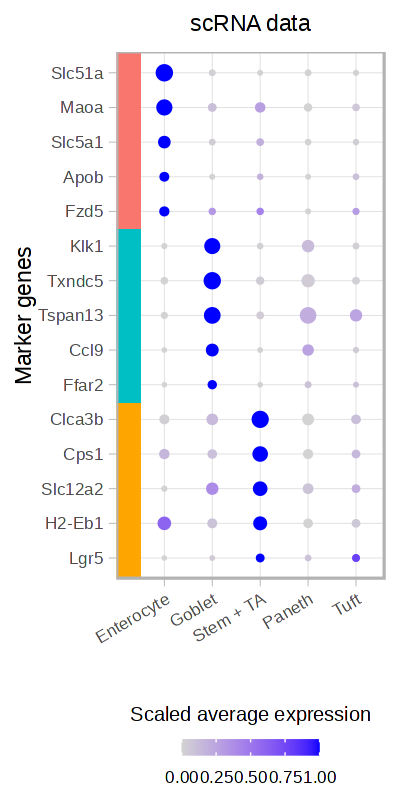

In [8]:
options(repr.plot.width = 2, repr.plot.height = 4, repr.plot.res = 200)

p <- DotPlot(object = sc_obj, features = markers_plot,
             col.min = 0,col.max = 5)

p$data$avg.exp.scaled <- NA
p_dat_lst <- lapply(markers_plot,function(g) {
  p_dat_sub <- p$data[p$data$features.plot==g,]
  X <- p_dat_sub$avg.exp
  min_val <- min(X)
  max_val <- max(X)
  X_std = (X - min_val) / (max_val - min_val)
  p_dat_sub$avg.exp.scaled <- X_std
  return(p_dat_sub)
})

p_dat_lst2 <- do.call(rbind.data.frame,p_dat_lst)

p$data <- p_dat_lst2

p$layers[[1]] <- NULL

sep_ndx1 <- length(markers_plot) - 9.5
sep_ndx2 <- length(markers_plot) - 4.5

p_sc <- p +
  geom_point(mapping = aes_string(size = 'pct.exp', color = 'avg.exp.scaled')) + # change to avg.exp.log or avg.exp.log.scaled or avg.exp.scaled
  coord_flip() +
  xlab('Marker genes') +
  ylab('') +
  ggtitle('scRNA data') +
  theme_light(base_line_size = gg_line_thickness) +
  scale_radius(range = c(0,2)) +
  p_theme +
  theme(axis.text.x = element_text(angle = 30, vjust = 1, hjust=1),
        legend.key.size = unit(6, 'pt'),
        legend.key.height = unit(6, 'pt'),
        legend.key.width = unit(10, 'pt'),
        legend.title=element_text(size=7),
        legend.text=element_text(size=6),
        legend.position="bottom",
        legend.box="vertical", legend.margin=margin()) +
  guides(colour = guide_colourbar(title.position="top", title.hjust = 0.5),
         size = 'none') +
  labs(colour="Scaled average expression") +
  annotate(
    ymin = 0, ymax = .5, # width
    xmin = c(-Inf,sep_ndx1,sep_ndx2), xmax = c(sep_ndx1,sep_ndx2,Inf), # height for each section
    geom = "rect",
    fill = c("orange", "#00BFC4", "#F8766D"))

p_sc

In [9]:
# subset spatial data to the same cell types
cells_keep <- colnames(seurat_spatial)[Idents(seurat_spatial) %in% c('Goblet','Enterocyte','Stem + TA','Paneth','Tuft')]
seurat_spatial <- subset(seurat_spatial,cells=cells_keep)
Idents(seurat_spatial) <- factor(Idents(seurat_spatial),levels=c('Enterocyte','Goblet','Stem + TA','Paneth','Tuft'))

Scale for size is already present.
Adding another scale for size, which will replace the existing scale.


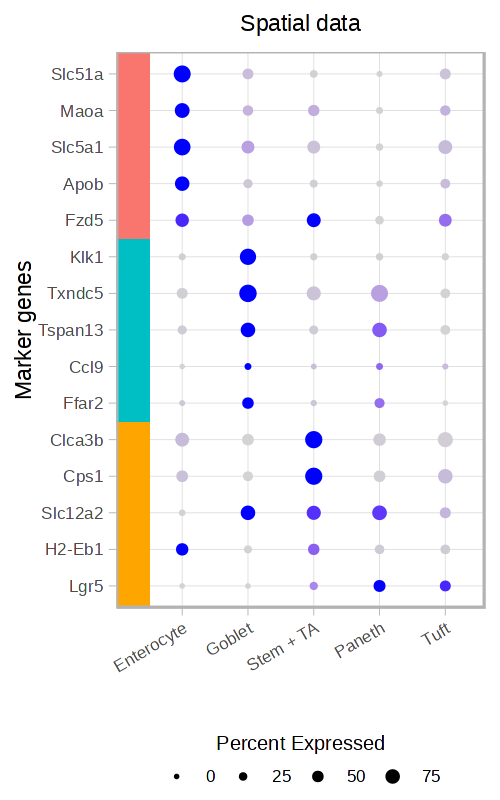

In [10]:
options(repr.plot.width = 2.5, repr.plot.height = 4, repr.plot.res = 200)

##### making version to show the average log(cpm+1)
p <- DotPlot(object = seurat_spatial, features = markers_plot,
             col.min = 0,col.max = 5)

p$data$avg.exp.scaled <- NA
p_dat_lst <- lapply(markers_plot,function(g) {
  p_dat_sub <- p$data[p$data$features.plot==g,]
  X <- p_dat_sub$avg.exp
  min_val <- min(X)
  max_val <- max(X)
  X_std = (X - min_val) / (max_val - min_val)
  p_dat_sub$avg.exp.scaled <- X_std
  return(p_dat_sub)
})

p_dat_lst2 <- do.call(rbind.data.frame,p_dat_lst)

p$data <- p_dat_lst2

p$layers[[1]] <- NULL

sep_ndx1 <- length(markers_plot) - 9.5
sep_ndx2 <- length(markers_plot) - 4.5

p_spat <- p +
  geom_point(mapping = aes_string(size = 'pct.exp', color = 'avg.exp.scaled')) +
  coord_flip() +
  xlab('Marker genes') +
  ylab('') +
  ggtitle('Spatial data') +
  theme_light(base_line_size = gg_line_thickness) +
  scale_radius(range = c(0,2)) +
  p_theme +
  theme(axis.text.x = element_text(angle = 30, vjust = 1, hjust=1),
        legend.key.size = unit(6, 'pt'),
        legend.key.height = unit(6, 'pt'),
        legend.key.width = unit(10, 'pt'),
        legend.title=element_text(size=7),
        legend.text=element_text(size=6),
        legend.position="bottom",
        legend.box="vertical", legend.margin=margin()) +
  guides(colour = 'none',
         size = guide_legend(title.position="top", title.hjust = 0.5)) +
  labs(size="Percent Expressed") +
  annotate(
    ymin = 0, ymax = .5, # width
    xmin = c(-Inf,sep_ndx1,sep_ndx2), xmax = c(sep_ndx1,sep_ndx2,Inf), # height for each section
    geom = "rect",
    fill = c("orange", "#00BFC4", "#F8766D"))

p_spat

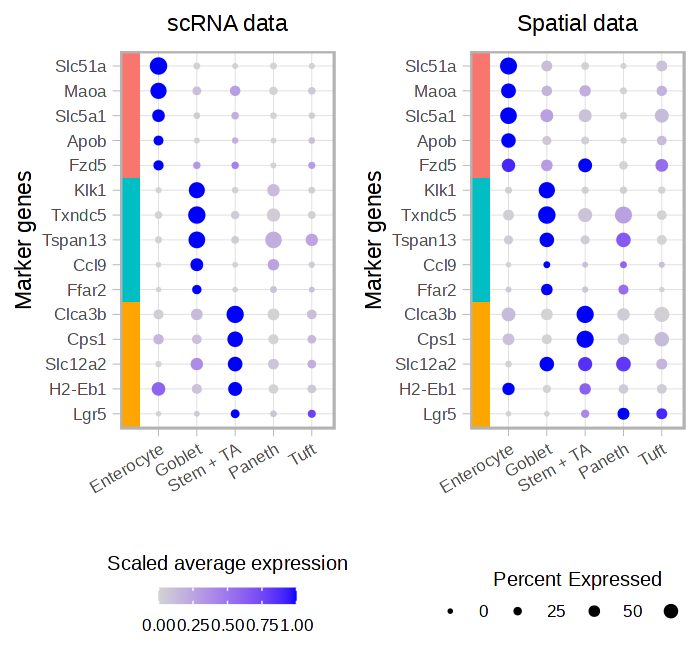

In [11]:
options(repr.plot.width = 3.5, repr.plot.height = 3.25, repr.plot.res = 200)

fig <- plot_grid(p_sc,p_spat,nrow=1,rel_widths = c(.5,.5),align = 'hv')
fig

In [12]:
pdf(OutputPath("gut_sc_spatial_marker_dotplots.pdf"), useDingbats=FALSE, width=3.5, height=3.25)
fig
dev.off()

png 
  2